In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("../datasets/03-unloaded-res.csv")

df.time = df.time.astype(int)
df.time = df.time - 2

df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,4004,4047,130,224,335,1150,7794
1,2,4004,4004,128,207,318,1019,7111
2,3,4000,4000,116,226,350,494,1003
3,4,4000,3998,126,225,342,626,9862
4,5,4004,4006,123,205,314,606,3793


In [3]:
latencia = df[['time', 'latency_median']]

# latencia = latencia.set_index('time')

latencia.columns = [['time','latency']]


latencia.head()

,time,latency
0,1,224
1,2,207
2,3,226
3,4,225
4,5,205


In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(latencia.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



ValueError: x is required to have ndim 1 but has ndim 2

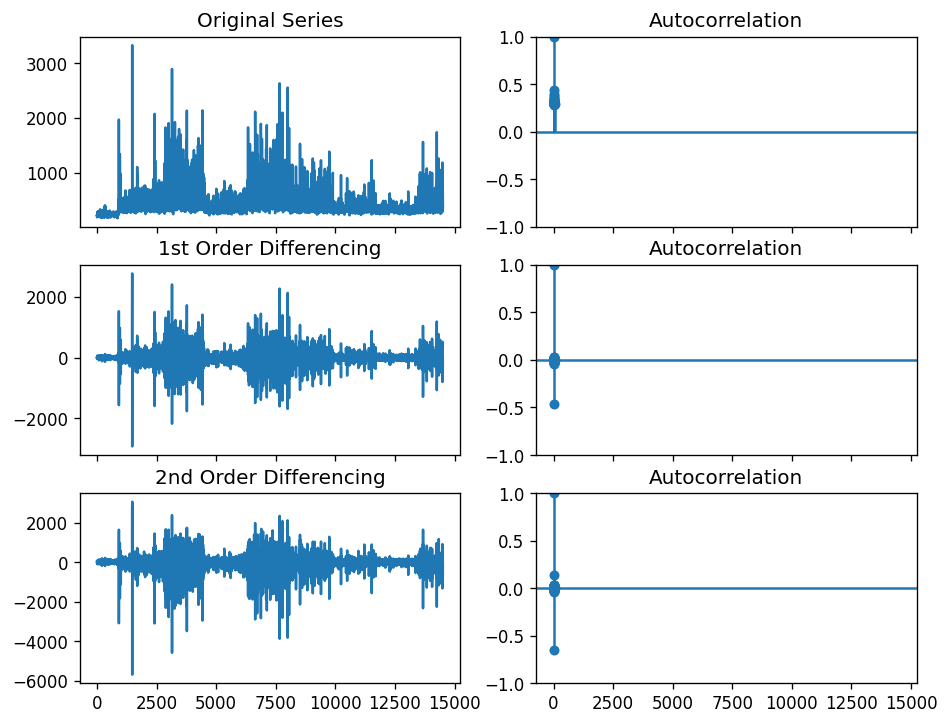

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(latencia.latency); axes[0, 0].set_title('Original Series')
plot_acf(latencia.latency, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(latencia.latency.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(latencia.latency.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(latencia.latency.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(latencia.latency.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

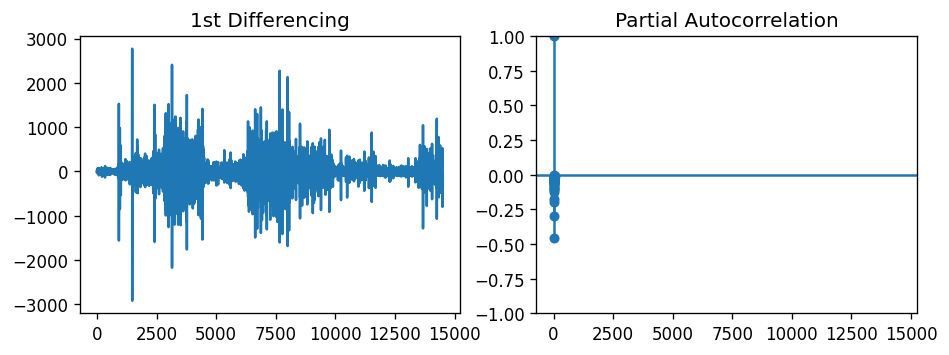

In [6]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(latencia.latency.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(latencia.latency.diff().dropna(), ax=axes[1])

plt.show()

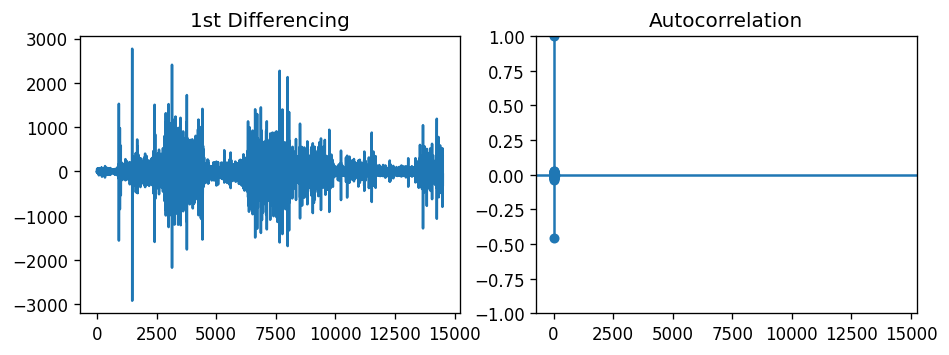

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(latencia.latency.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(latencia.latency.diff().dropna(), ax=axes[1])

plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(latencia.latency, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                latency   No. Observations:                14510
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -92746.565
Date:                Sun, 17 Nov 2024   AIC                         185501.130
Time:                        18:18:18   BIC                         185531.460
Sample:                             0   HQIC                        185511.209
                              - 14510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7420      0.014     53.507      0.000       0.715       0.769
ma.L1         -1.5625      0.016    -94.903      0.000      -1.595      -1.530
ma.L2          0.5697      0.016     35.700      0.0

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(latencia.latency, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                latency   No. Observations:                14510
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -92831.618
Date:                Sun, 17 Nov 2024   AIC                         185669.236
Time:                        18:18:38   BIC                         185691.984
Sample:                             0   HQIC                        185676.796
                              - 14510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1668      0.005     33.069      0.000       0.157       0.177
ma.L1         -0.9599      0.002   -533.968      0.000      -0.963      -0.956
sigma2      2.113e+04     55.718    379.214      0.0

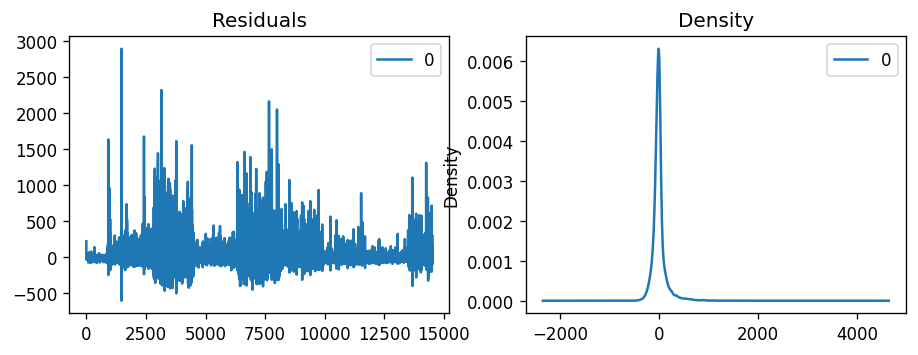

In [11]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

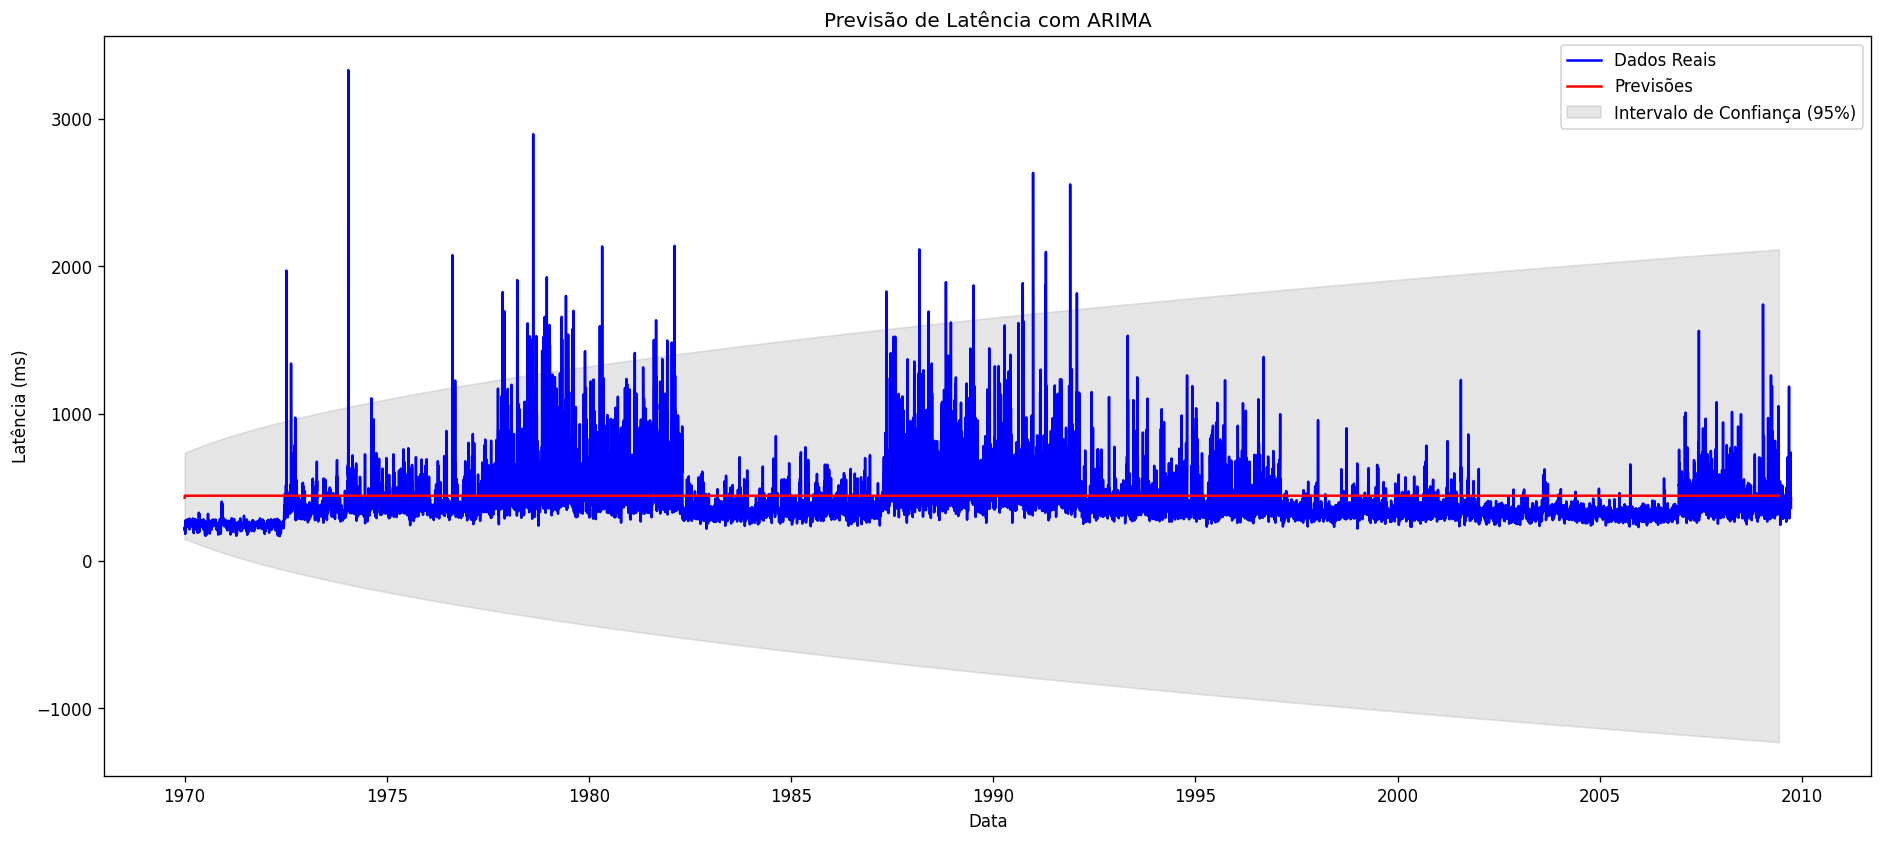

In [13]:
forecast_steps = 14400

# Usando get_forecast() para obter previsões, intervalo de confiança e erro padrão
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
stderr = forecast_result.se_mean  # Erro padrão das previsões
conf_int = forecast_result.conf_int(alpha=0.05)  # Intervalo de confiança de 95%

# Gerando as datas futuras para as previsões
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plotando os dados reais e as previsões
plt.figure(figsize=(19, 8))
plt.plot(latencia.time, latencia.latency, label='Dados Reais', color='blue')
plt.plot(forecast_index, forecast_values, label='Previsões', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança (95%)')

# Títulos e labels
plt.title("Previsão de Latência com ARIMA")
plt.xlabel("Data")
plt.ylabel("Latência (ms)")
plt.legend()
plt.show()

In [14]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = latencia[:10000]
test = latencia[10000:]



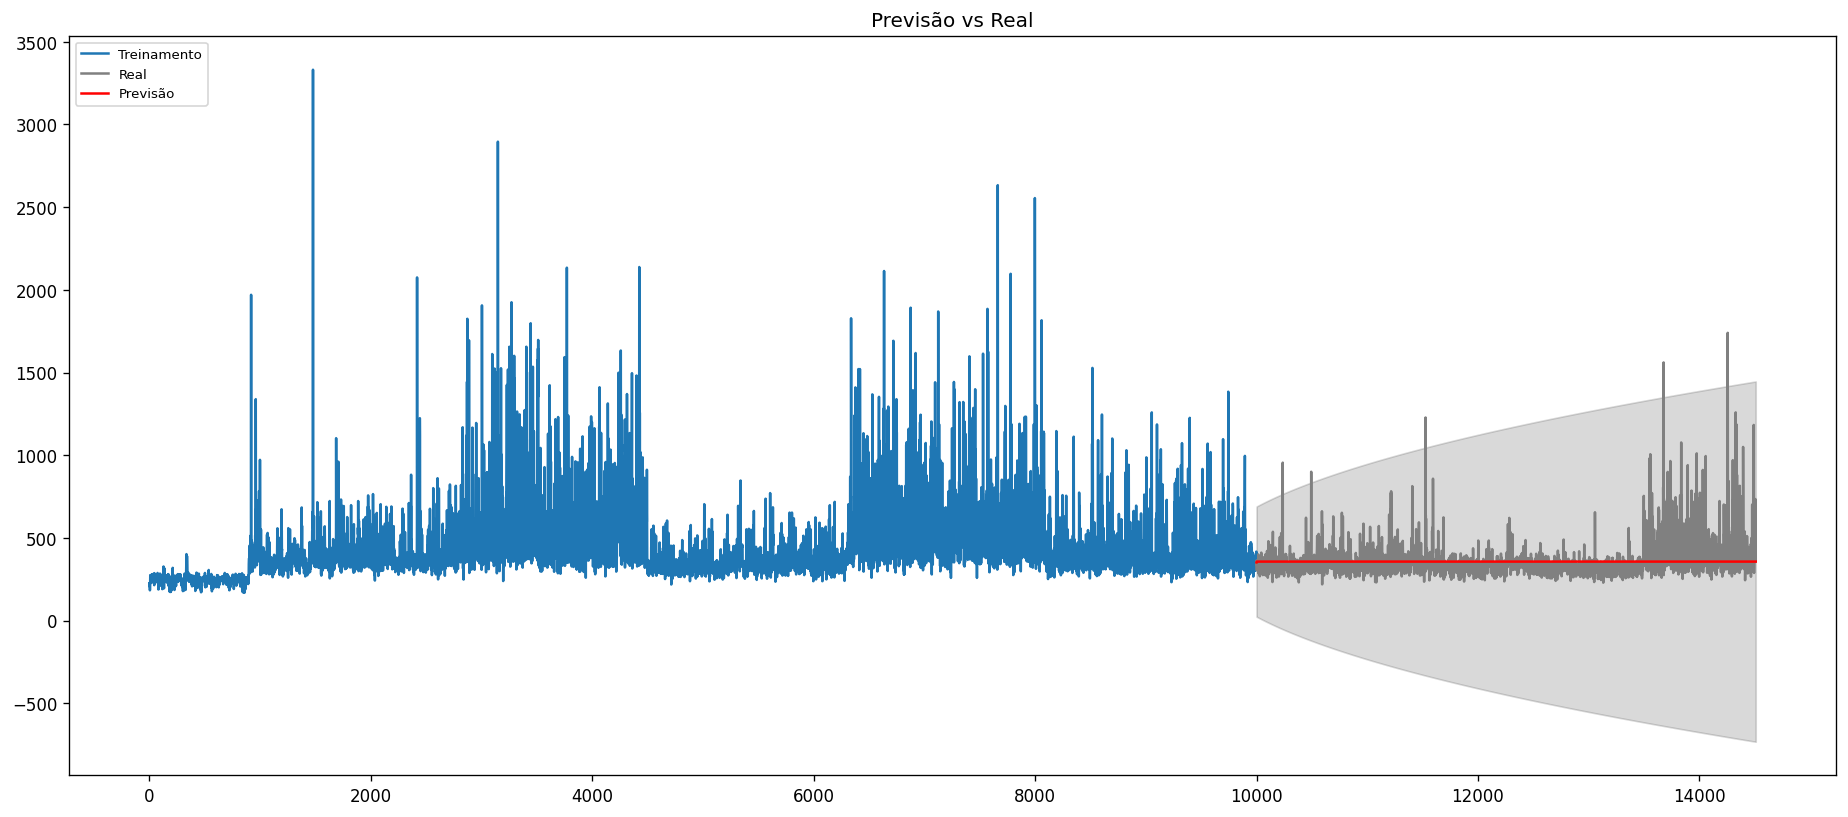

In [20]:
model = ARIMA(train.latency, order=(1, 1, 1))
fitted = model.fit()

# Gerando previsões para os próximos 119 passos (tamanho do conjunto de teste)
forecast_steps = 5000

# Usando get_forecast() para obter previsões, intervalo de confiança e erro padrão
forecast_result = fitted.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
stderr = forecast_result.se_mean  # Erro padrão das previsões
conf_int = forecast_result.conf_int(alpha=0.05)  # Intervalo de confiança de 95%

# Convertendo as previsões em pandas Series
fc_series = pd.Series(forecast_values, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

# Plotando os dados de treinamento, teste, previsões e intervalo de confiança
plt.figure(figsize=(19, 8), dpi=120)
plt.plot(train.latency, label='Treinamento')
plt.plot(test.latency, label='Real', color='gray')
plt.plot(fc_series, label='Previsão', color='red')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Previsão vs Real')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Outra Abordagem

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

%matplotlib inline

# plt.style.use('seaborn-v0_8-colorblind')

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("../datasets/unloaded-teste-concorrencia-deterministico.csv")

df.time = df.time.astype(int)
df.time = df.time - 1

df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,1,1000,1000,158,216,281,430,1144
1,2,1001,1001,163,206,263,549,1040
2,3,1000,1000,157,205,266,353,1304
3,4,1001,1001,159,206,268,375,1454
4,5,1001,1001,148,194,258,372,1584


In [3]:
latencia = df[['time', 'latency_median']]

latencia = latencia.set_index('time')

# latencia.columns = [['time','latency']]


latencia.head()

,latency_median
time,
1,216
2,206
3,205
4,206
5,194


In [4]:
ts = latencia.latency_median

ts.head()

time
1    216
2    206
3    205
4    206
5    194
Name: latency_median, dtype: int64

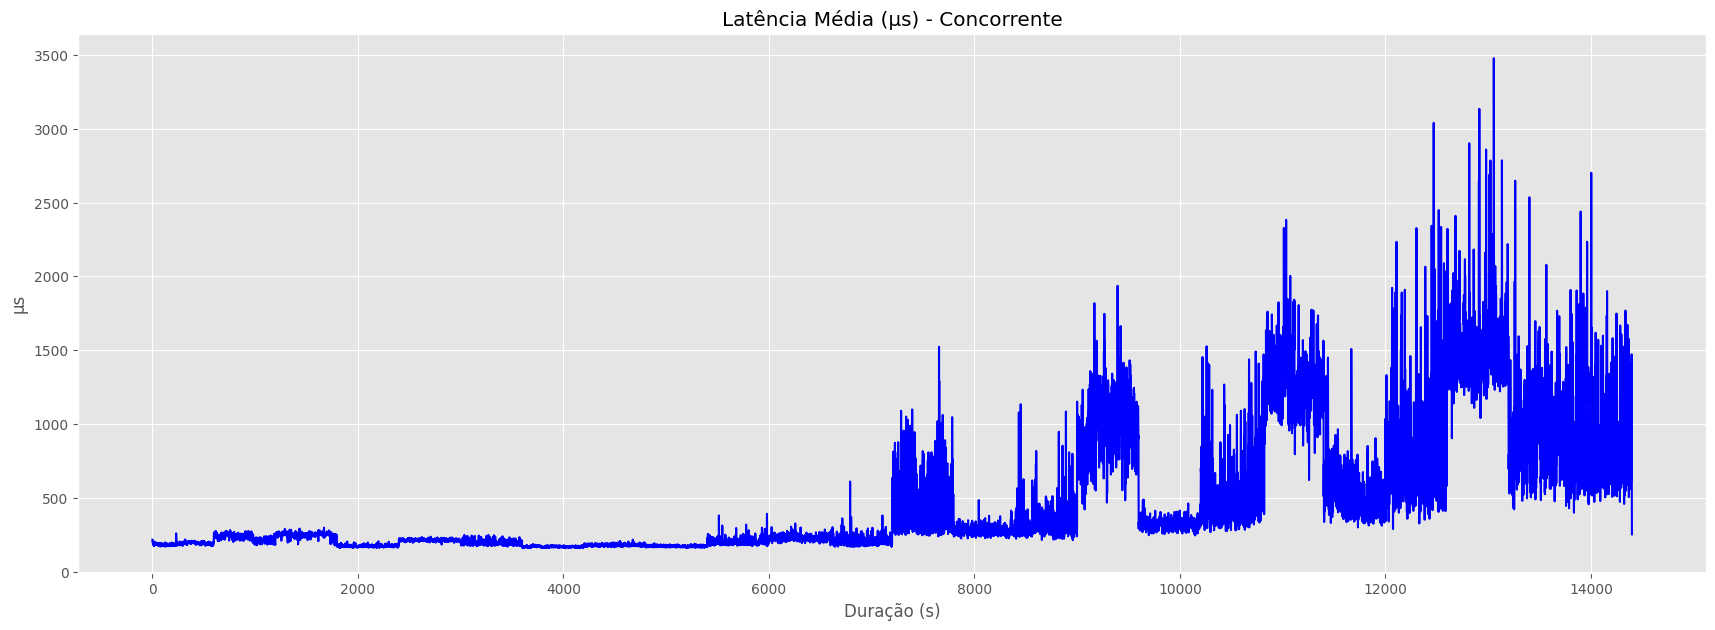

In [5]:
plt.figure(figsize=(21, 7))

# assintotas = [0, 1800, 5400, 9000, 12600, 14400]
# for x in assintotas:
#     plt.axvline(x=x, color='red', linestyle='--', label=f'Assíntota em x = {x}')

plt.plot(latencia, color='blue')
plt.title('Latência Média (µs) - Concorrente')
plt.xlabel('Duração (s)')
plt.ylabel("µs")
# plt.grid(True)
plt.show()

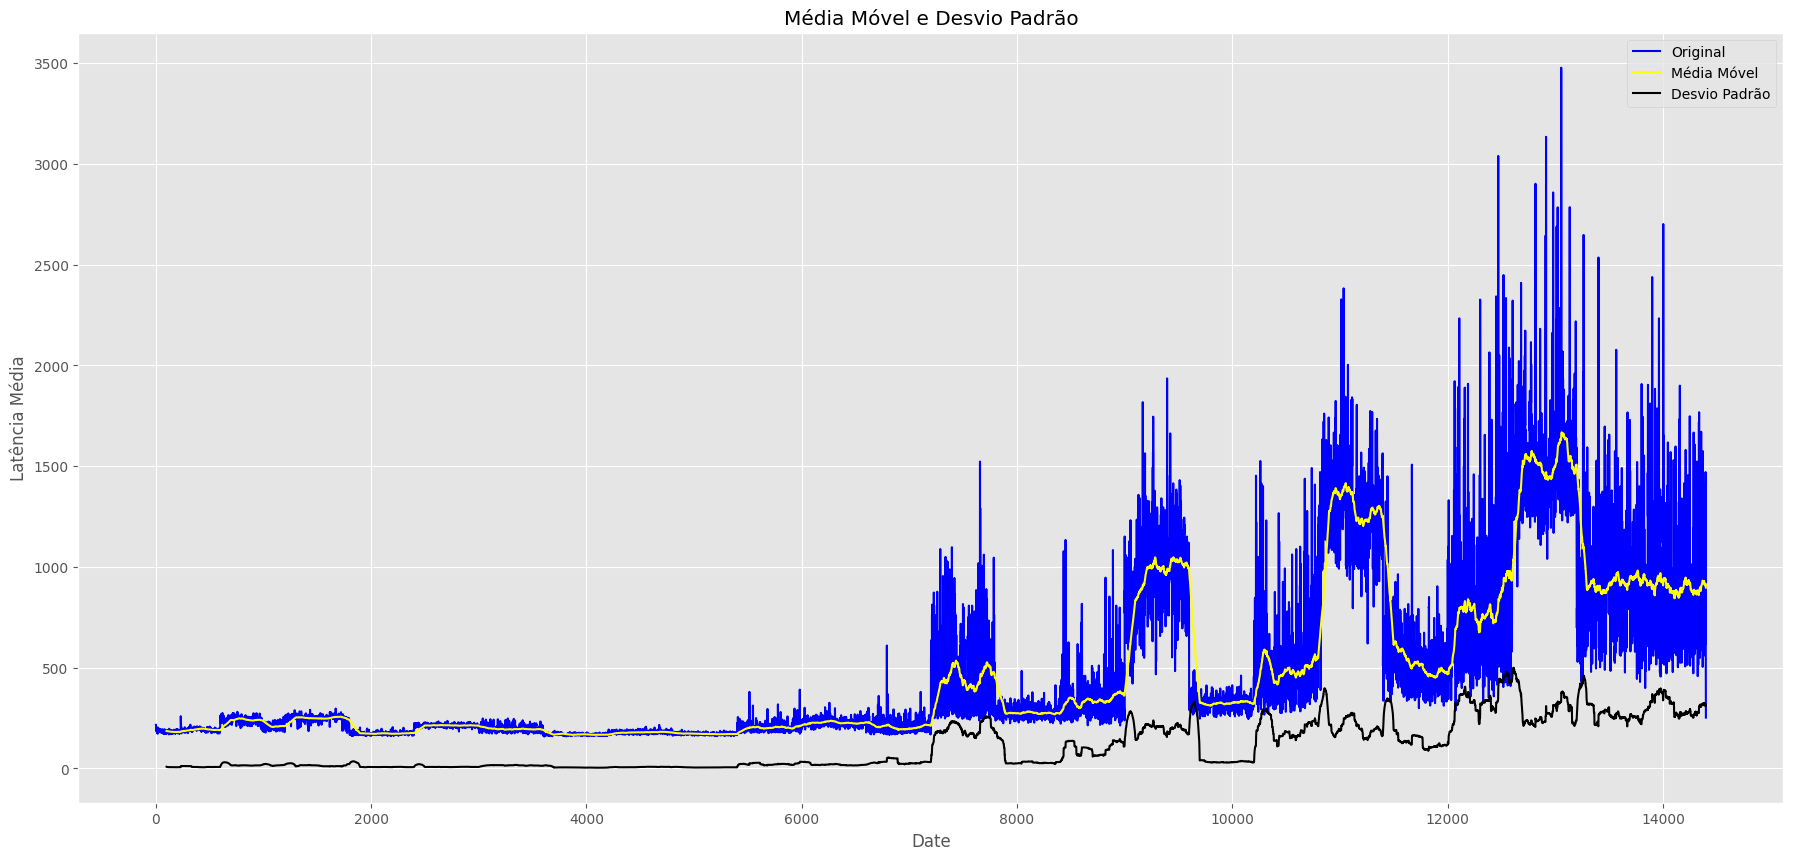

Test statistic:  -2.411268123986618
p-value:  0.13858128837396633
Critical Values: {'1%': np.float64(-3.430805591366162), '5%': np.float64(-2.861741351011649), '10%': np.float64(-2.566877174398671)}


In [6]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    rolmean = pd.Series(ts).rolling(window=100).mean()
    rolstd = pd.Series(ts).rolling(window=100).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='blue', label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.xlabel("Date")
    plt.ylabel("Latência Média")
    plt.title('Média Móvel e Desvio Padrão')
    plt.legend()
    plt.show()
    
check_mean_std(ts)
check_adfuller(ts)

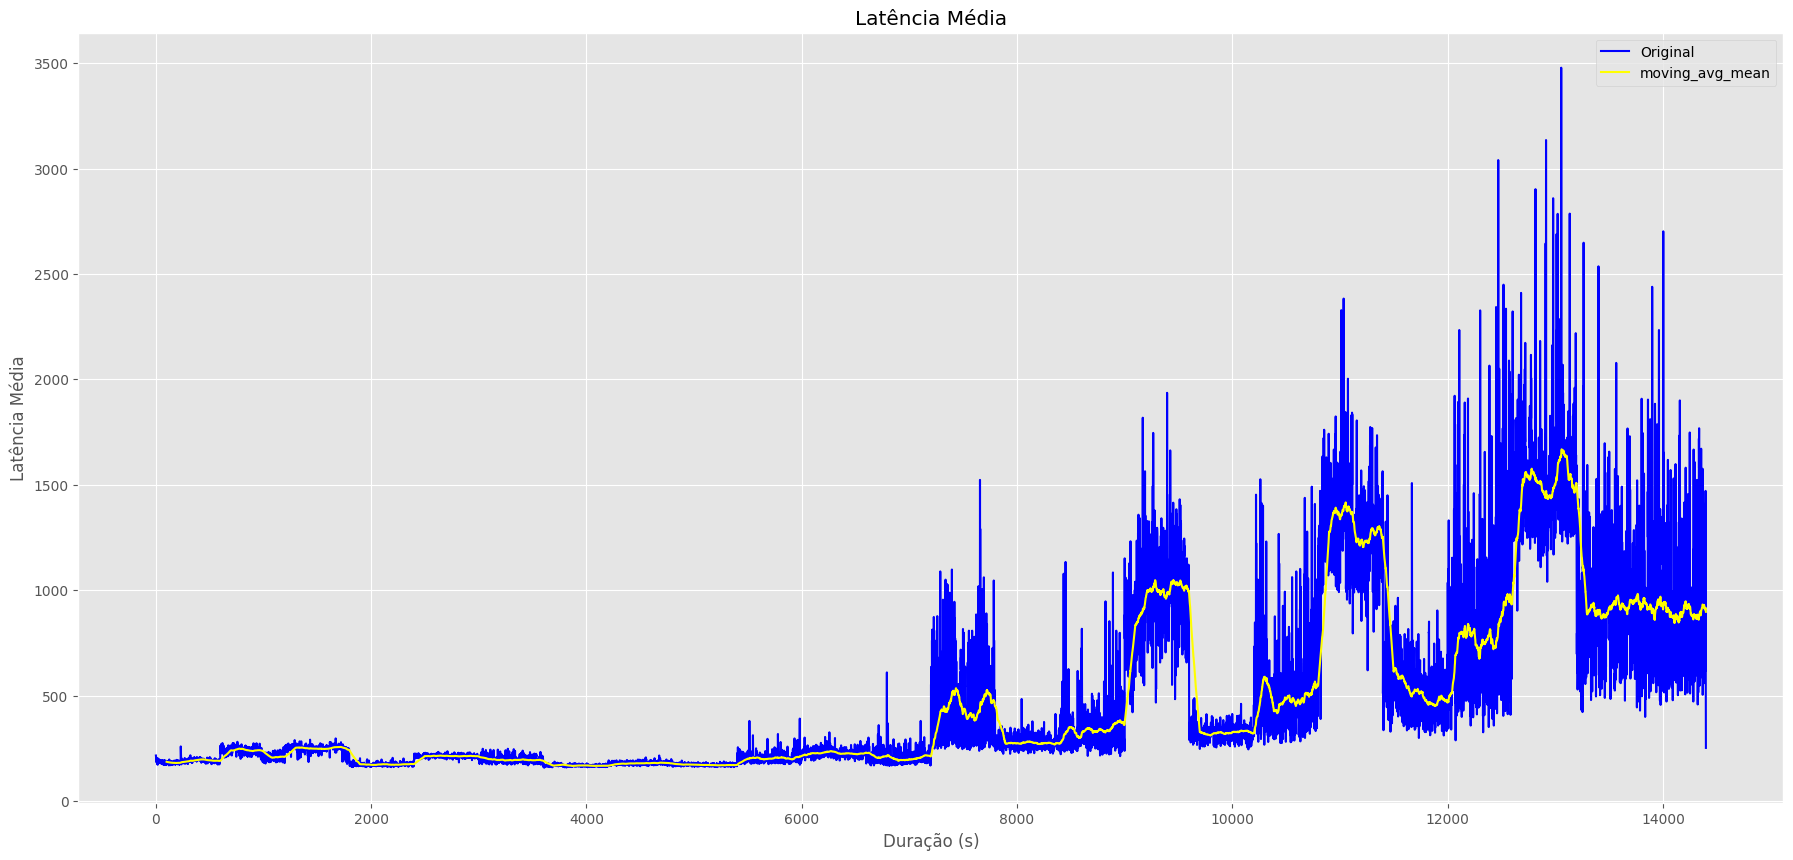

In [7]:
window_size = 100
moving_avg = pd.Series(ts).rolling(window=100).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color='blue', label = "Original")
plt.plot(moving_avg, color='yellow', label = "moving_avg_mean")
plt.title("Latência Média")
plt.xlabel("Duração (s)")
plt.ylabel("Latência Média")
plt.legend()
plt.show()


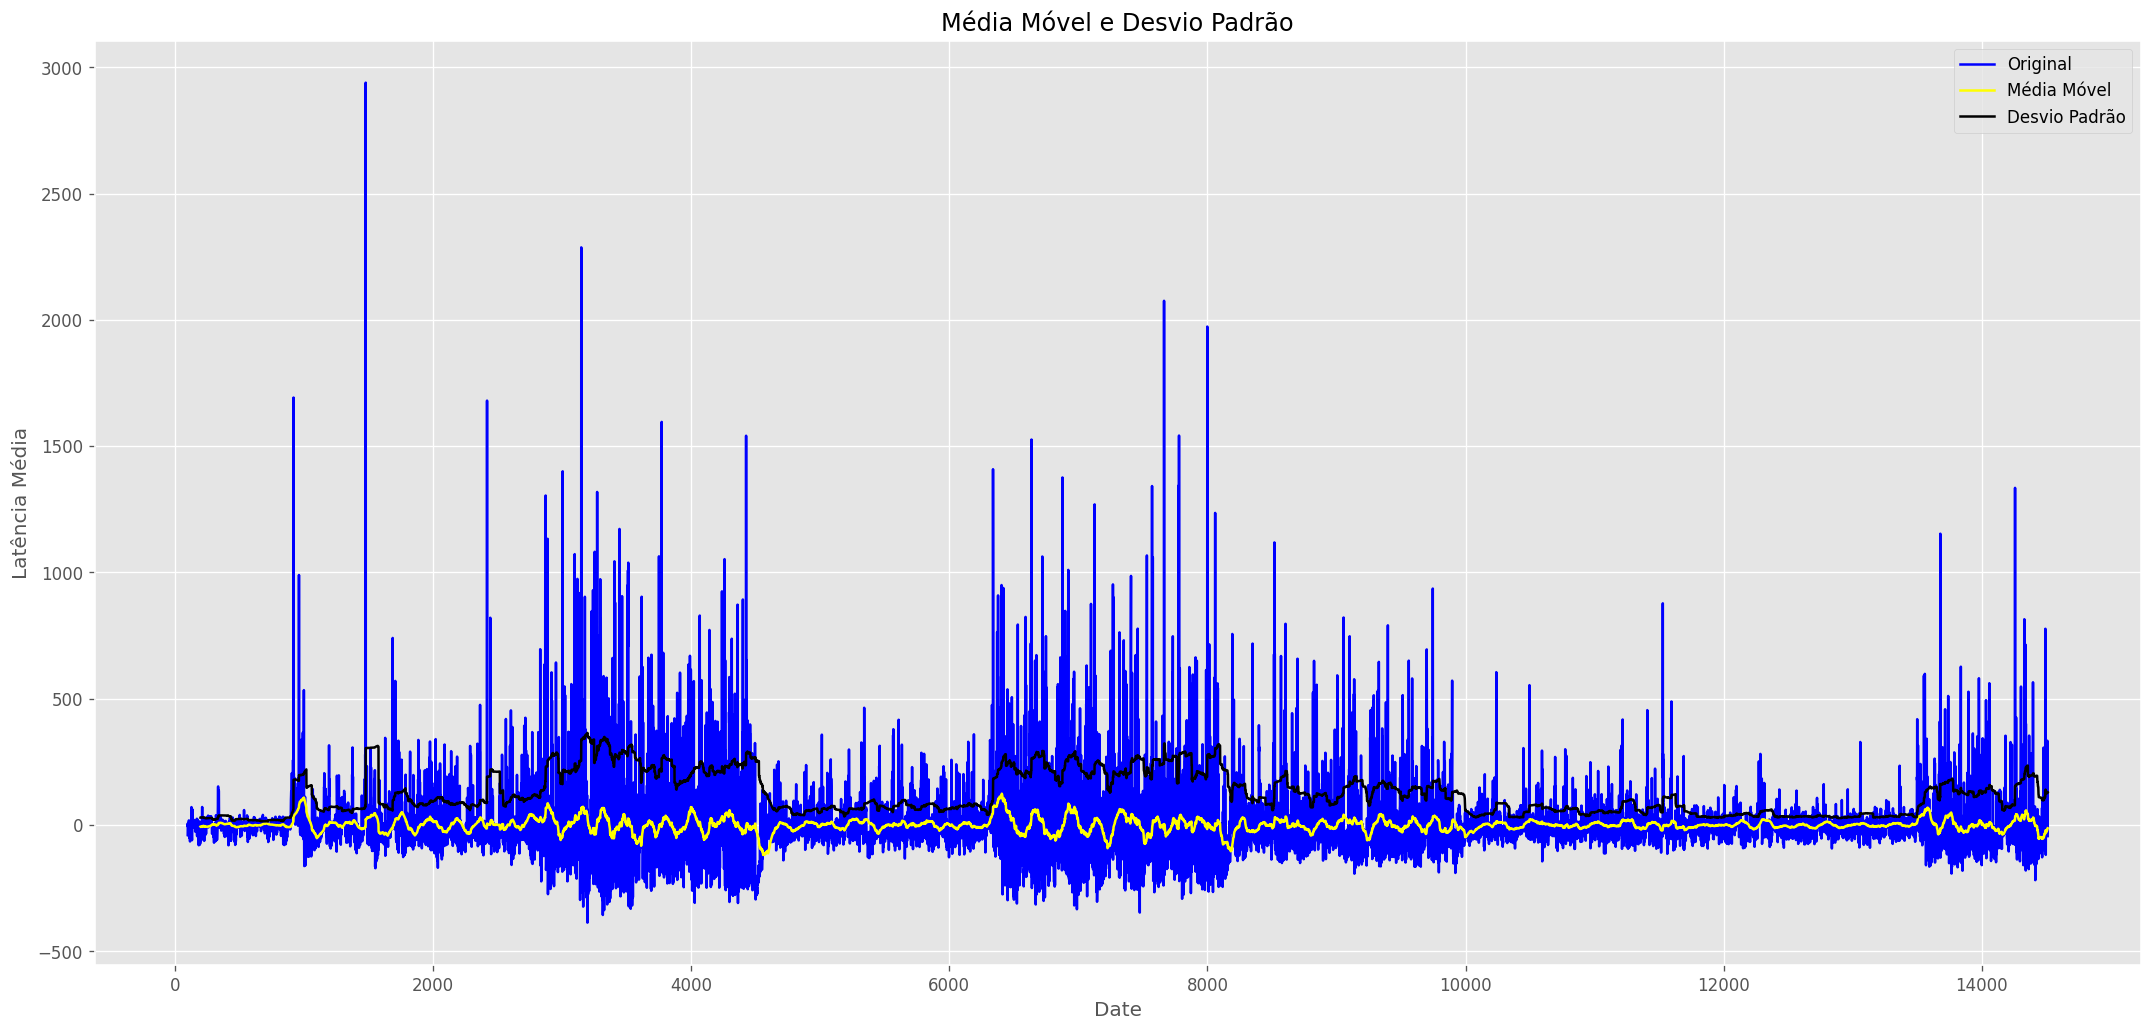

Test statistic:  -17.92733089889965
p-value:  2.891617947743117e-30
Critical Values: {'1%': np.float64(-3.430804925780315), '5%': np.float64(-2.8617410568749997), '10%': np.float64(-2.5668770178327547)}


In [39]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff)

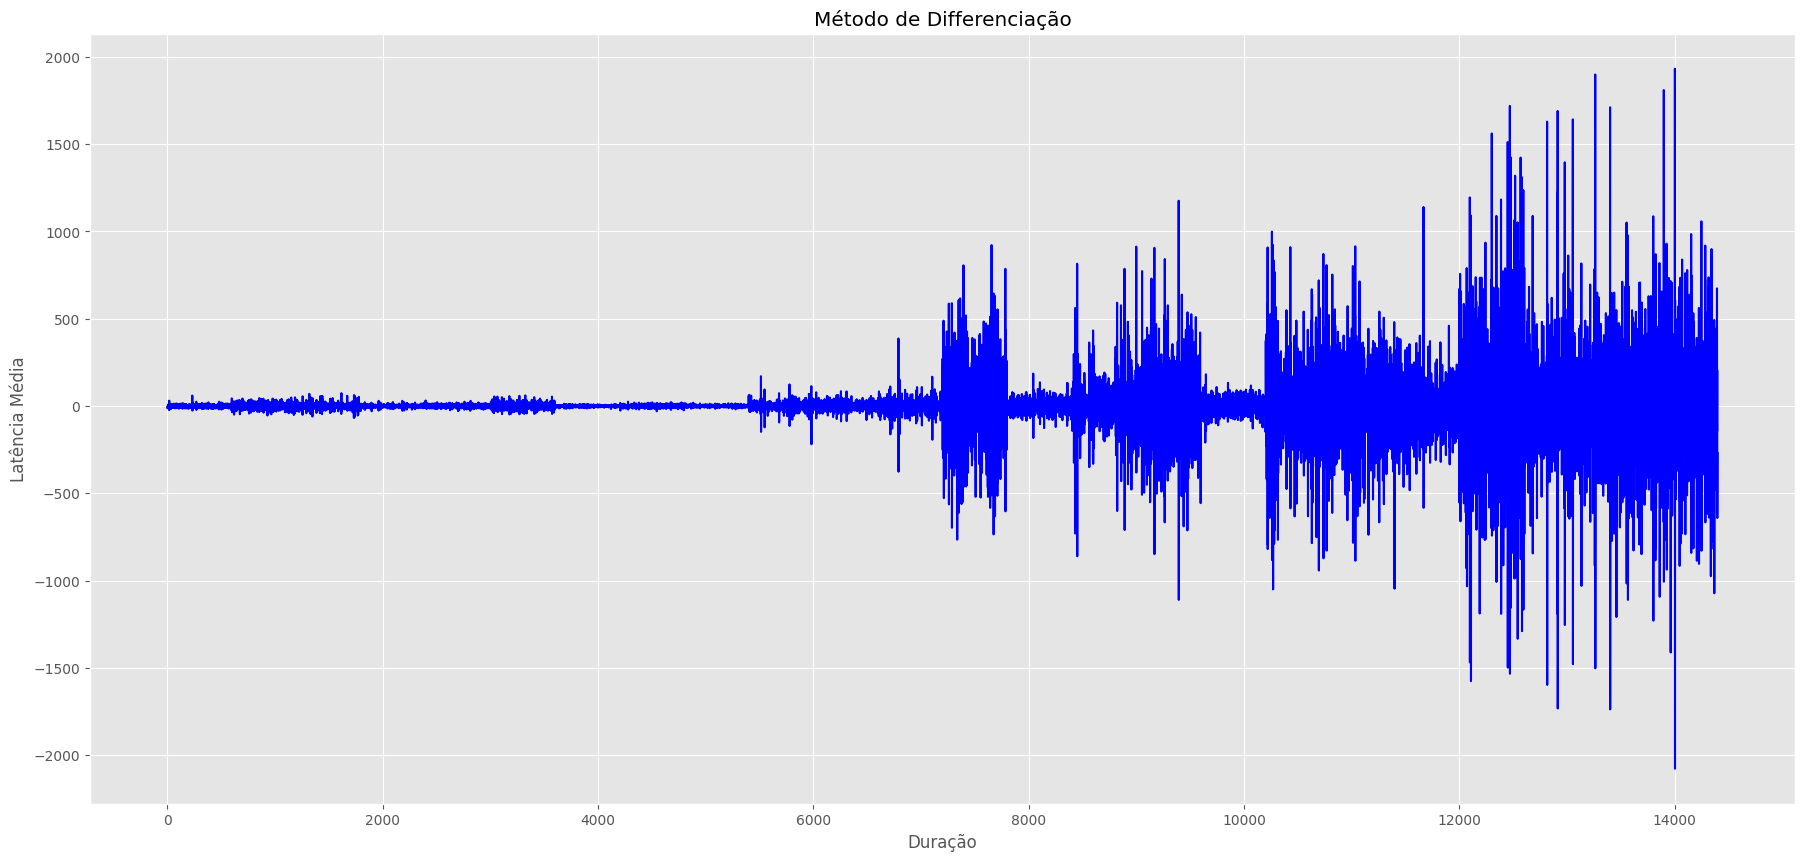

In [8]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff, color='blue')
plt.title("Método de Differenciação") 
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.show()

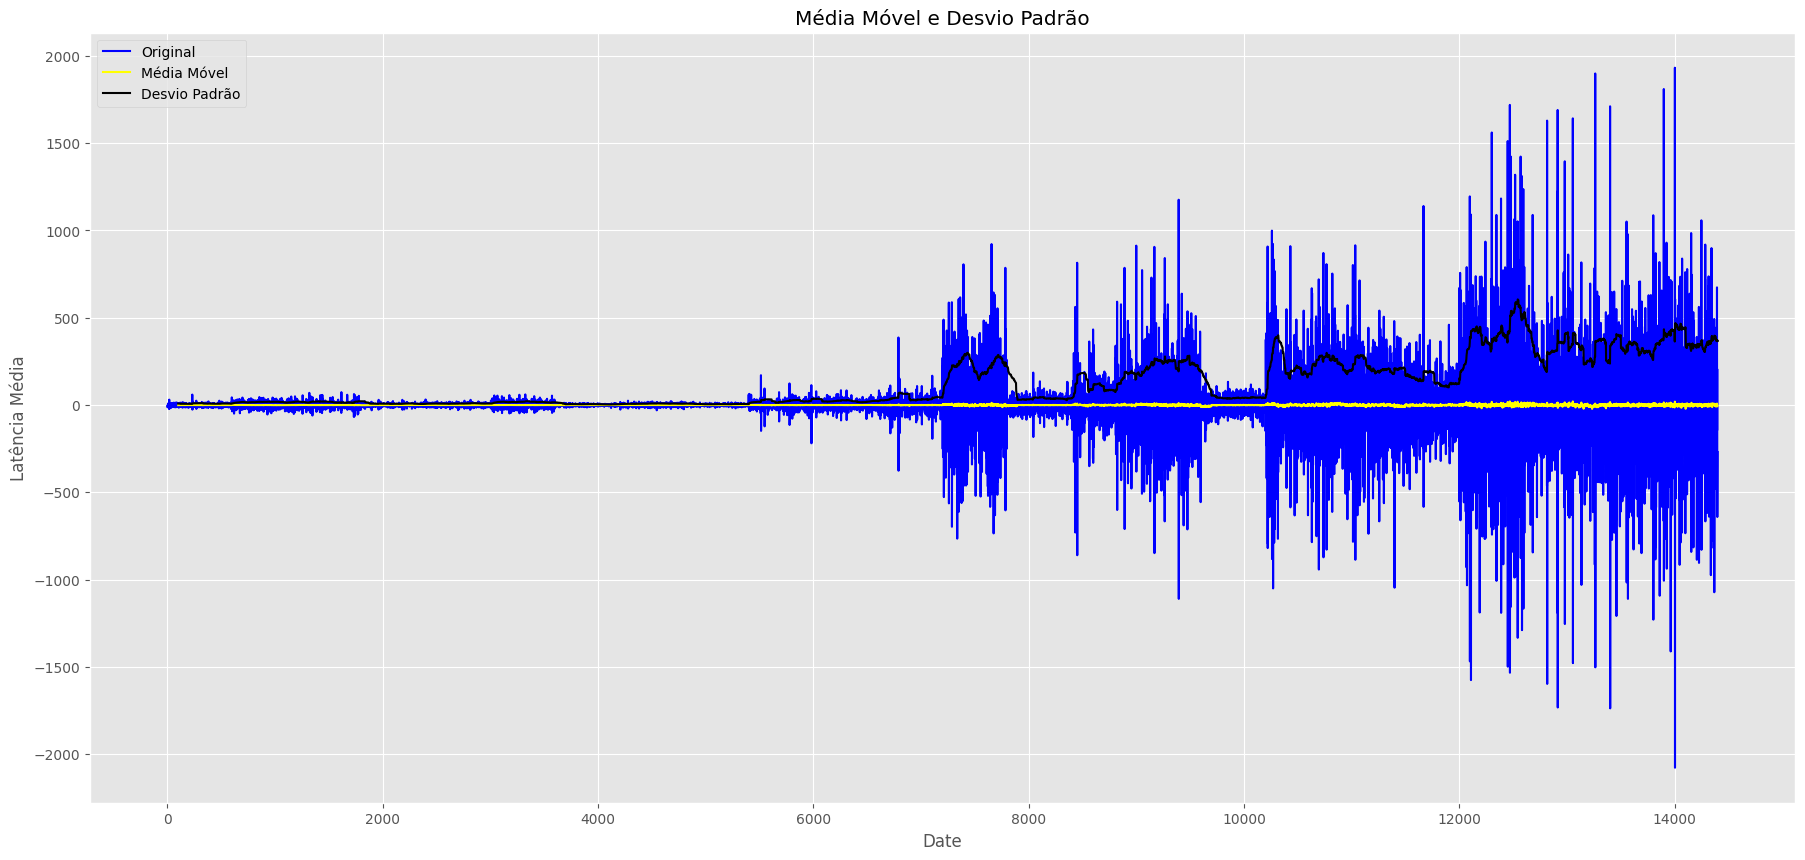

Test statistic:  -26.266843882287894
p-value:  0.0
Critical Values: {'1%': np.float64(-3.430805623109309), '5%': np.float64(-2.861741365039624), '10%': np.float64(-2.566877181865618)}


In [9]:
ts_diff.dropna(inplace=True)

check_mean_std(ts_diff)
check_adfuller(ts_diff)

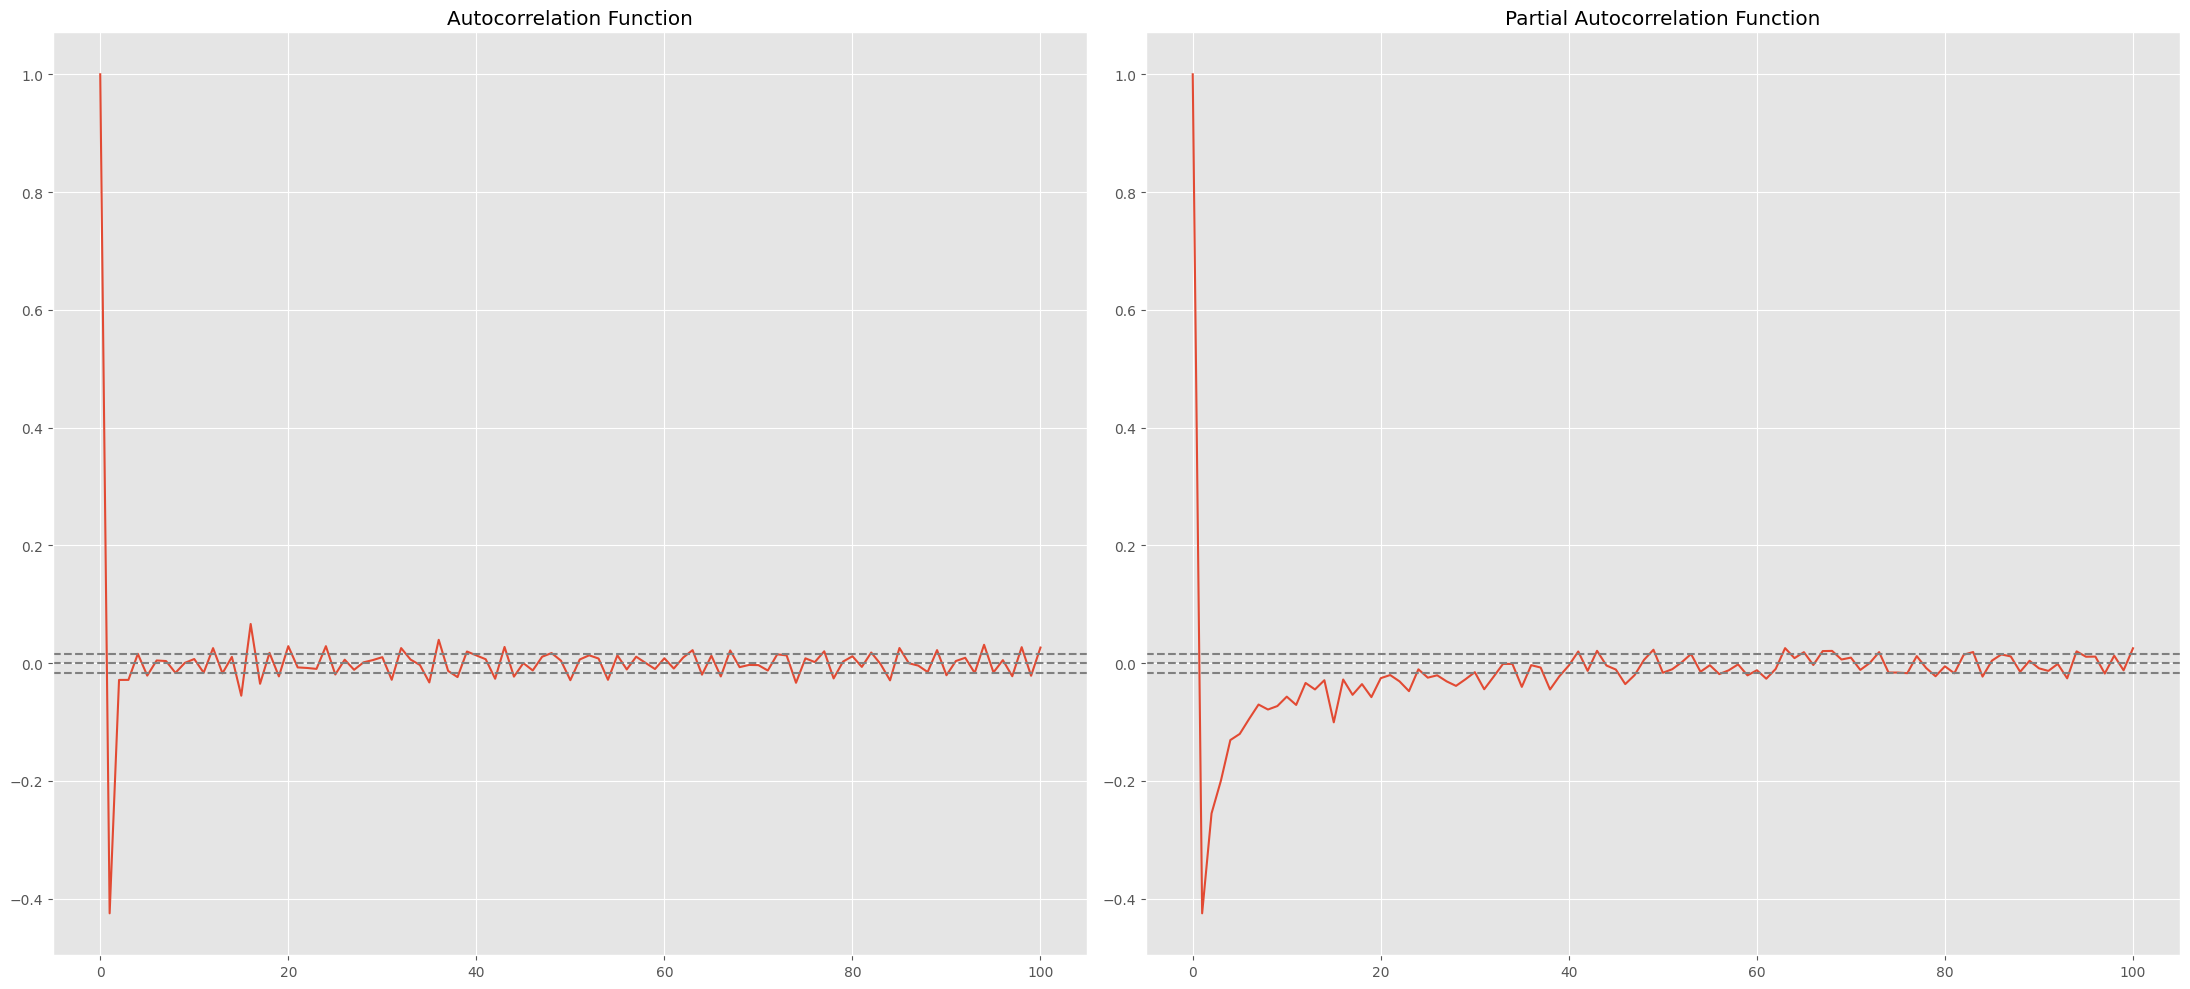

In [10]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=100)
lag_pacf = pacf(ts_diff, nlags=100, method='ols')


# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/phil/Projects/svc-degradatio

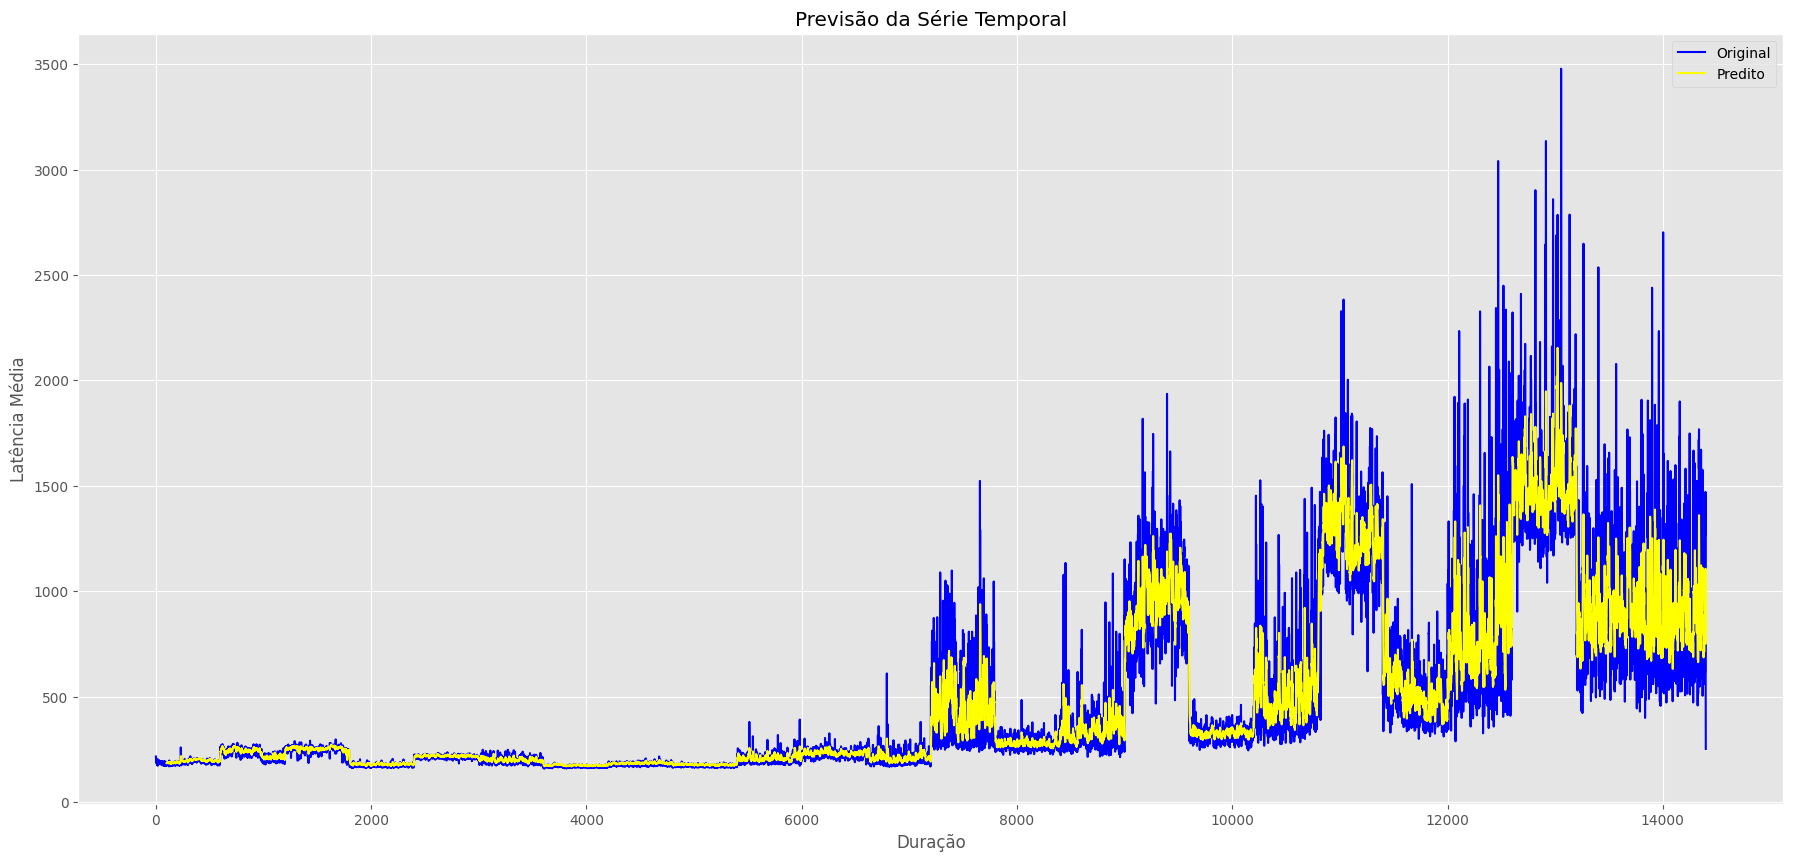

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Ajuste o 'ts' para a sua série temporal (por exemplo, 'latencia' ou 'ts')
# ts = seu_data_series

# Ajuste o modelo ARIMA
model = ARIMA(ts, order=(1,0,1))  # ARMA (1,0,1) com p=1, d=0, q=1
model_fit = model.fit()

# Previsão
start_index = 100
end_index = 14400
forecast = model_fit.predict(start=start_index, end=end_index)

# Visualização
plt.figure(figsize=(22, 10))
plt.plot(ts, label="Original", color='blue')  # Série original
plt.plot(range(start_index, end_index+1), forecast, label="Predito", color='yellow')  # Previsão
plt.title("Previsão da Série Temporal")
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.legend()
plt.show()


/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/phil/Projects/svc-degradation-detection/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


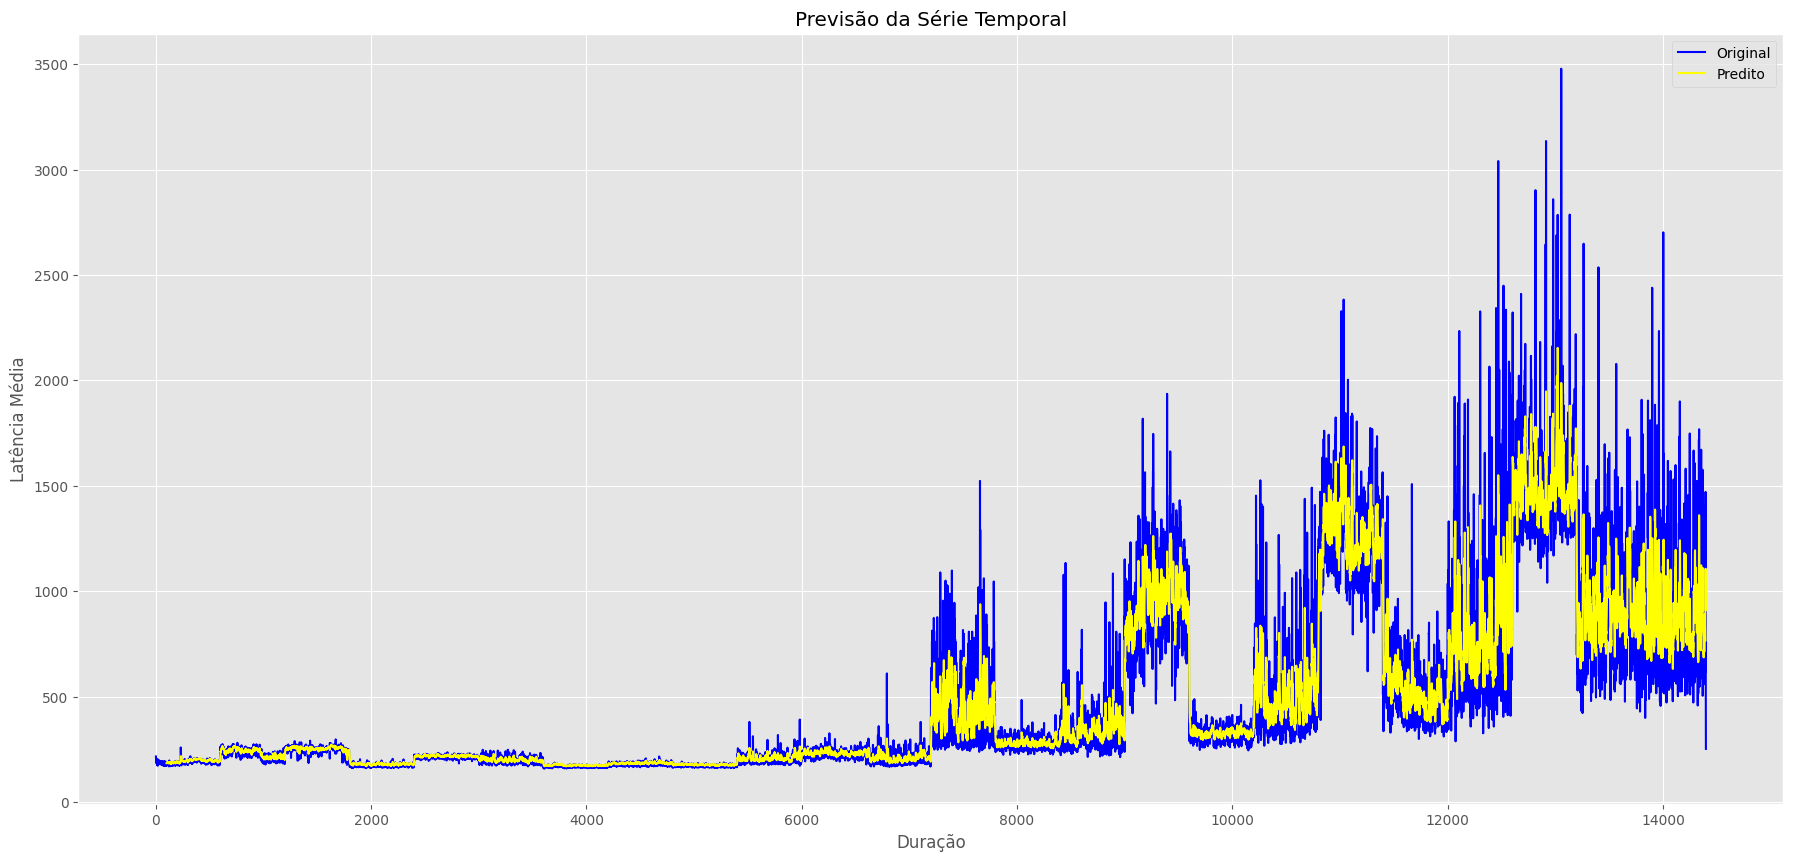

Erro Absoluto Médio (MAE): 76.1080
Erro Quadrático Médio (RMSE): 154.6920

Resumo do Modelo ARIMA:
                               SARIMAX Results                                
Dep. Variable:         latency_median   No. Observations:                14399
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -92974.540
Date:                Mon, 18 Nov 2024   AIC                         185957.080
Time:                        08:51:10   BIC                         185987.380
Sample:                             0   HQIC                        185967.153
                              - 14399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4257    120.408      3.890      0.000     232.431     704.421
ar.L1          0.9954      0.001

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ajuste o 'ts' para a sua série temporal (por exemplo, 'latencia' ou 'ts')
# ts = seu_data_series

# Ajuste o modelo ARIMA
model = ARIMA(ts, order=(1, 0, 1))  # ARMA (1, 0, 1) com p=1, d=0, q=1
model_fit = model.fit()

# Previsão
start_index = 100
end_index = 14398
forecast = model_fit.predict(start=start_index, end=end_index)

# Visualização
plt.figure(figsize=(22, 10))
plt.plot(ts, label="Original", color='blue')  # Série original
plt.plot(range(start_index, end_index+1), forecast, label="Predito", color='yellow')  # Previsão
plt.title("Previsão da Série Temporal")
plt.xlabel("Duração")
plt.ylabel("Latência Média")
plt.legend()
plt.show()

# Avaliação de desempenho do modelo
# Aqui, você deve ter os valores reais para a comparação. Supondo que `ts` seja a série original
# e que os valores reais para a previsão estejam no intervalo [start_index:end_index+1]
actual_values = ts[start_index:end_index+1]

# Calcular o erro absoluto médio (MAE) e o erro quadrático médio (RMSE)
mae = mean_absolute_error(actual_values, forecast)
rmse = np.sqrt(mean_squared_error(actual_values, forecast))

# Exibir as métricas de desempenho
print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
print(f"Erro Quadrático Médio (RMSE): {rmse:.4f}")

# Exibir o resumo do modelo para mais informações sobre o ajuste
print("\nResumo do Modelo ARIMA:")
print(model_fit.summary())


In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.411268123986618
p-value: 0.13858128837396633
